Dataset Preparation

In [3]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import cv2
from PIL import Image

# Download CIFAR-10 (without transforms)
trainset = CIFAR10(root='./data', train=True, download=True)
testset = CIFAR10(root='./data', train=False, download=True)

class CIFAR10_HQ_vs_Degraded(Dataset):
    def __init__(self, base_dataset, degrade=False):
        self.base_dataset = base_dataset
        self.degrade = degrade
        self.final_transform = transforms.Compose([
            transforms.Resize((224, 224)),  # ResNet input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
        ])

    def degrade_image(self, img):
        """Apply Gaussian blur + noise to degrade."""
        img_np = np.array(img)
        img_np = cv2.GaussianBlur(img_np, (5, 5), 2)  # Blur
        noise = np.random.normal(0, 25, img_np.shape).astype(np.uint8)  # Noise
        img_np = cv2.add(img_np, noise)
        return Image.fromarray(np.clip(img_np, 0, 255).astype('uint8'))

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]  # PIL image
        if self.degrade:
            img = self.degrade_image(img)
            label = 1  # Degraded
        else:
            label = 0  # High-quality
        img = self.final_transform(img)
        return img, label

# Combine datasets
hq_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=False)
degraded_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=True)
combined_dataset = torch.utils.data.ConcatDataset([hq_dataset, degraded_dataset])

# Split into train/test
train_size = int(0.8 * len(combined_dataset))
test_size = len(combined_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, test_size])

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

Load and Modify ResNet

In [4]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet18 (or ResNet34/50)
resnet = models.resnet18(pretrained=False)

#Load the manually downloaded weights
resnet.load_state_dict(torch.load(r"C:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\resnet18-f37072fd.pth", map_location=device))


# Freeze all layers except final layer (optional)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for binary classification
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)  # 2 classes (HQ vs. degraded)
resnet = resnet.to(device)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Training Loop

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

for epoch in range(10):
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1, Loss: 0.0074, Accuracy: 99.88%
Epoch 2, Loss: 0.0007, Accuracy: 99.99%
Epoch 3, Loss: 0.0006, Accuracy: 99.98%
Epoch 4, Loss: 0.0003, Accuracy: 99.99%
Epoch 5, Loss: 0.0004, Accuracy: 99.99%
Epoch 6, Loss: 0.0007, Accuracy: 99.98%
Epoch 7, Loss: 0.0002, Accuracy: 99.99%
Epoch 8, Loss: 0.0003, Accuracy: 99.99%
Epoch 9, Loss: 0.0004, Accuracy: 99.99%
Epoch 10, Loss: 0.0002, Accuracy: 99.99%


Evaluation

In [7]:
resnet.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 99.99%


In [5]:
from sklearn.metrics import classification_report

all_preds_resnet = []
all_labels_resnet = []

resnet.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = outputs.max(1)
        all_preds_resnet.extend(preds.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

print("ResNet18 Classification Report:")
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=['High Quality','Degraded']))


ResNet18 Classification Report:
              precision    recall  f1-score   support

High Quality       0.33      0.51      0.40      9896
    Degraded       0.01      0.00      0.00     10104

    accuracy                           0.25     20000
   macro avg       0.17      0.26      0.20     20000
weighted avg       0.17      0.25      0.20     20000



Save the Model

In [8]:
torch.save(resnet.state_dict(), "resnet18_cifar10_degradation.pth")

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate ResNet18 architecture
resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)  # Binary classification

# Load trained weights
resnet.load_state_dict(torch.load("resnet18_cifar10_degradation.pth", map_location=device))
resnet = resnet.to(device)
resnet.eval()


c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['High Quality', 'Degraded']))


              precision    recall  f1-score   support

High Quality       1.00      1.00      1.00      9896
    Degraded       1.00      1.00      1.00     10104

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



Inference Script

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_model(filepath):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Assuming binary classification
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_quality(image_path, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(img_tensor)
        prob = torch.softmax(outputs, dim=1)[0]
        predicted_class = torch.argmax(prob).item()
    
    classes = ["High Quality", "Degraded"]
    confidence = prob[predicted_class].item()
    return classes[predicted_class], confidence

# Example usage
model = load_model("resnet18_cifar10_degradation.pth")
label, confidence = predict_quality("test_image.jpg", model)
print(f"Prediction: {label} (Confidence: {confidence:.2%})")


Prediction: High Quality (Confidence: 61.50%)


Confusion Matrix (Classification Performance)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


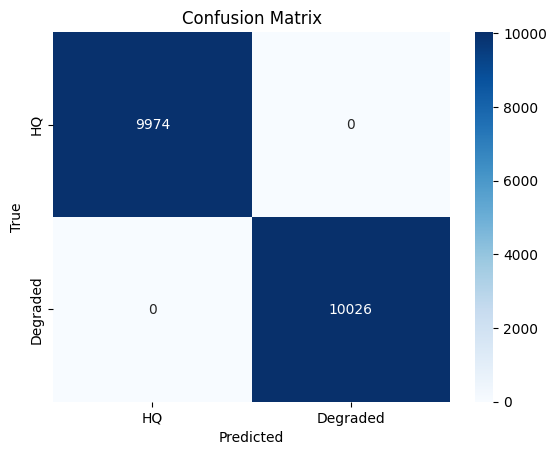

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['HQ', 'Degraded'], 
                yticklabels=['HQ', 'Degraded'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
model = load_model("resnet18_cifar10_degradation.pth")  # Already defined earlier
plot_confusion_matrix(model, test_loader)

In [ ]:
print(classification_report(all_labels, all_preds, target_names=['High Quality','Degraded']))

ROC Curve & AUC (Threshold Sensitivity)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


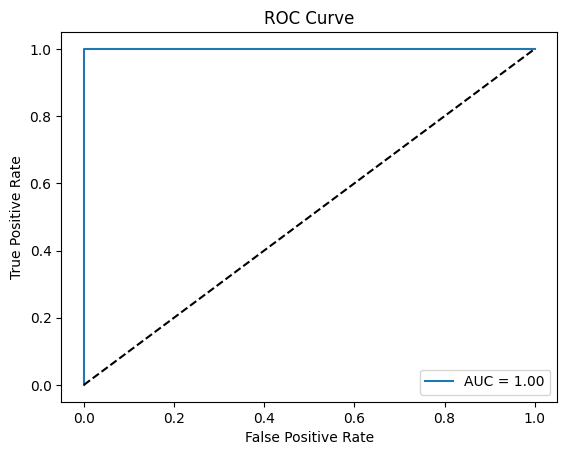

In [7]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, dataloader):
    model.eval()
    y_true, y_scores = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = torch.softmax(model(images), dim=1)
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs[:, 1].cpu().numpy())  # Prob of "Degraded"
    
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
model = load_model("resnet18_cifar10_degradation.pth")  # Already defined earlier

plot_roc_curve(model, test_loader)

Grad-CAM (Model Interpretability)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


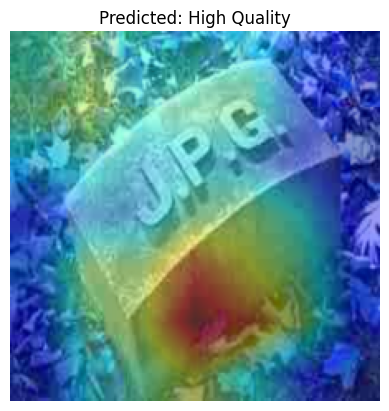

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the model
def load_model(filepath):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)  # Binary classification
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)
    model.eval()
    return model

# 2. Preprocess the image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image)  # [3, 224, 224]

# 3. Grad-CAM function
def grad_cam(model, image_tensor, target_layer):
    model.eval()
    image_tensor = image_tensor.to(device).unsqueeze(0)  # [1, 3, 224, 224]
    
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output.detach()

    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0].detach()

    # Register hooks
    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(image_tensor)
    pred_class = output.argmax().item()

    # Backward pass for target class
    one_hot = torch.zeros_like(output)
    one_hot[0][pred_class] = 1
    model.zero_grad()
    output.backward(gradient=one_hot)

    # Compute Grad-CAM
    grads = gradients['value']           # [1, C, H, W]
    acts = activations['value']         # [1, C, H, W]
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])  # [C]

    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(acts, dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.cpu().numpy()

    # Convert original image to numpy
    img = image_tensor.squeeze().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW → HWC
    img = (img * np.array([0.229, 0.224, 0.225]) +
           np.array([0.485, 0.456, 0.406]))
    img = np.clip(img, 0, 1)

    # Resize and overlay heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(np.uint8(255 * img), 0.6, heatmap, 0.4, 0)

    # Show
    plt.imshow(superimposed_img[..., ::-1])  # BGR → RGB
    plt.title(f"Predicted: {'Degraded' if pred_class == 1 else 'High Quality'}")
    plt.axis('off')
    plt.show()

    # Clean up hooks
    handle_fwd.remove()
    handle_bwd.remove()

# 4. Run Grad-CAM
if __name__ == "__main__":
    model = load_model("resnet18_cifar10_degradation.pth")
    target_layer = model.layer4[1].conv2  # Good layer for Grad-CAM in ResNet18
    image_tensor = preprocess_image("degraded_example.jpg")
    grad_cam(model, image_tensor, target_layer)


Class Activation Distribution

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\user\AppData\Local\Temp\ipykernel_5096\2782888611.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(hq_probs, label='HQ Confidence', shade=True)
C:\Users\user\AppData\Local\Temp\ipykernel_5096\2782888611.py:13: FutureWarning: 

`shade` is now 

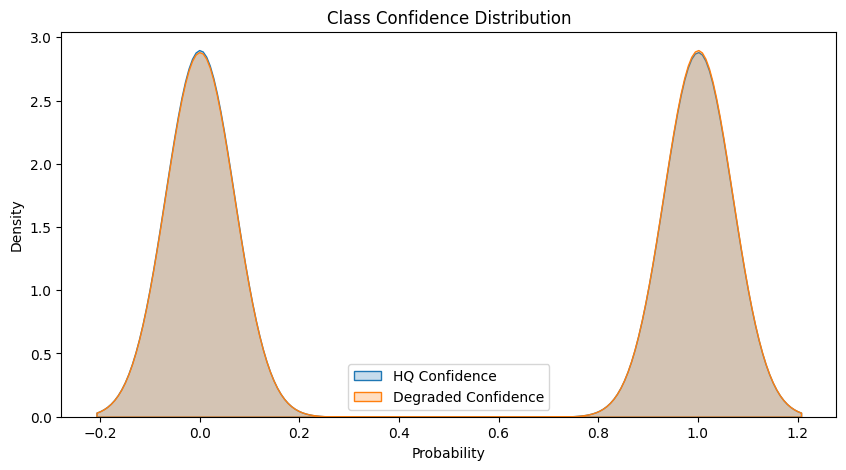

In [8]:
def plot_class_distribution(model, dataloader):
    model.eval()
    hq_probs, degraded_probs = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = torch.softmax(model(images), dim=1)
            hq_probs.extend(outputs[:, 0].cpu().numpy())
            degraded_probs.extend(outputs[:, 1].cpu().numpy())
    
    plt.figure(figsize=(10, 5))
    sns.kdeplot(hq_probs, label='HQ Confidence', shade=True)
    sns.kdeplot(degraded_probs, label='Degraded Confidence', shade=True)
    plt.xlabel('Probability')
    plt.ylabel('Density')
    plt.title('Class Confidence Distribution')
    plt.legend()
    plt.show()
model = load_model("resnet18_cifar10_degradation.pth")  # Already defined earlier

plot_class_distribution(model, test_loader)

Error Analysis (Top Misclassified Samples)

In [9]:
def show_top_errors(model, dataloader, n=5):
    model.eval()
    errors = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    errors.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            if len(errors) >= n:
                break
    
    plt.figure(figsize=(15, 5))
    for i, (img, true, pred) in enumerate(errors[:n]):
        img = img.permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) # Unnormalize
        plt.subplot(1, n, i+1)
        plt.imshow(img.clip(0, 1))
        plt.title(f"True: {'HQ' if true == 0 else 'Degraded'}\nPred: {'HQ' if pred == 0 else 'Degraded'}")
        plt.axis('off')
    plt.show()
model = load_model("resnet18_cifar10_degradation.pth")
show_top_errors(model, test_loader)

c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\OneDrive - Ulster University\Desktop\MSc Pro Work\msProCode\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<Figure size 1500x500 with 0 Axes>